## Zadanie 1

Proszę zaprojektować rozmyty system sterowania automatycznym podlewaniem grządki. Grządka ma 3m^2, a system podlewania może nawadniać w tempie maksymalnie 25l/dziennie, podczas, gdy zalecana ilość wody dla "zwyczajnych" warunków dla grządki w takim rozmiarze to 10l/dziennie.

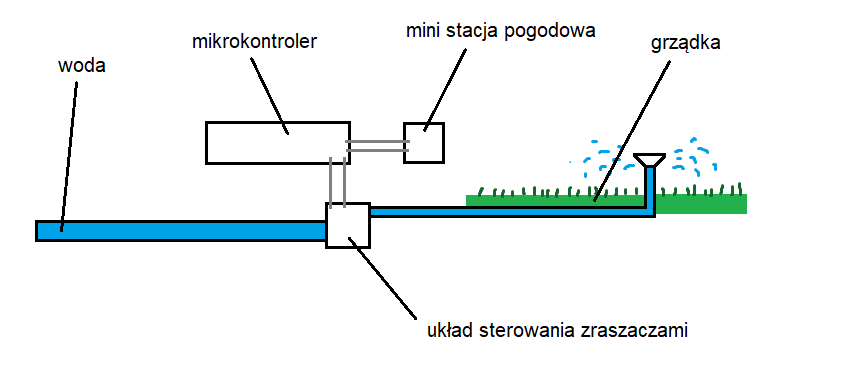

System jest sterowany elektronicznie i jest do niego podłączony higrometr (mierzący wilgotność względną w zakresie od 0% do 100%) i termometr. Temperatury są mierzone wyłącznie za dnia i znajdują się w zakresie 15°C - 35°C.Proszę zaprojektować układ rozmytego sterowania, układając reguły na podstawie następującej tabelki:

|                 | Sucho             | Przeciętnie                | Mokro      |
|-----------------|----------------------|----------------------|------------------|
| **Chłodno**     | Podlewaj średnio        | Podlewaj średnio     | Podlewaj mało    |
| **Ciepło**      | Podlewaj dużo        | Podlewaj średnio        | Podlewaj mało |
| **Gorąco**      | Podlewaj dużo | Podlewaj dużo        | Podlewaj średnio    |

Proszę samodzielnie zaproponować rozmyte funkcje przynależności i narysować je na wykresach. Proszę przedstawić heatmapę wynikowej funkcji ilości wody używanej dziennie w zależności od wilgotności i temperatury ukrytej w mechanizmie sterowania.

In [1]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import numpy as np

# define fuzzy variables
temperature = ctrl.Antecedent(np.arange(15, 35.1, 0.1), 'temperature')
humidity = ctrl.Antecedent(np.arange(0, 101, 1), 'humidity')
water = ctrl.Consequent(np.arange(0, 25.1, 0.1), 'water')

temperature['cold'] = fuzz.trapmf(temperature.universe, [15, 15, 18, 22])
temperature['warm'] = fuzz.trapmf(temperature.universe, [18, 22, 27, 29])
temperature['hot'] = fuzz.trapmf(temperature.universe, [27, 29, 35.1, 35.1])

humidity['dry'] = fuzz.trapmf(humidity.universe, [0, 0, 32, 50])
humidity['avg'] = fuzz.trapmf(humidity.universe, [32, 50, 67, 78])
humidity['humid'] = fuzz.trapmf(humidity.universe, [67, 78, 101, 101])

water['little'] = fuzz.trimf(water.universe, [0, 5, 10])
water['medium'] = fuzz.trimf(water.universe, [5, 10, 15])
water['a_lot'] = fuzz.trimf(water.universe, [10, 20, 25])

/Users/zen1x/AGH/S6/MIO/.venv/lib/python3.13/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


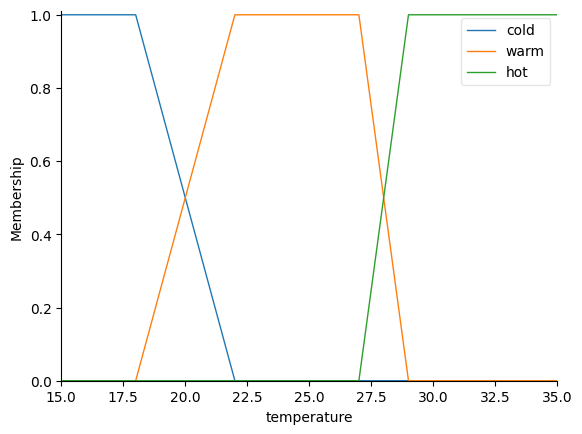

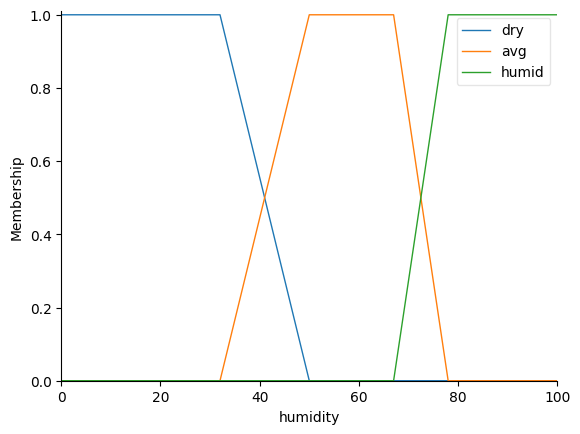

In [2]:
# show rules
temperature.view()
humidity.view()

In [3]:
# define rules
rule1 = ctrl.Rule(temperature['cold'] & (humidity['dry'] | humidity['avg']), water['medium'])
rule2 = ctrl.Rule(temperature['cold'] & humidity['humid'], water['little'])

rule3 = ctrl.Rule(humidity['dry'] & (temperature['warm'] | temperature['hot']), water['a_lot'])

rule4 = ctrl.Rule(temperature['warm'] & humidity['avg'], water['medium'])
rule5 = ctrl.Rule(temperature['warm'] & humidity['humid'], water['little'])

rule6 = ctrl.Rule(temperature['hot'] & humidity['avg'], water['a_lot'])
rule7 = ctrl.Rule(temperature['hot'] & humidity['humid'], water['medium'])

In [4]:
# create control system
control_system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7])

# create a model based on the control system
model = ctrl.ControlSystemSimulation(control_system)

<Axes: xlabel='temperature', ylabel='humidity'>

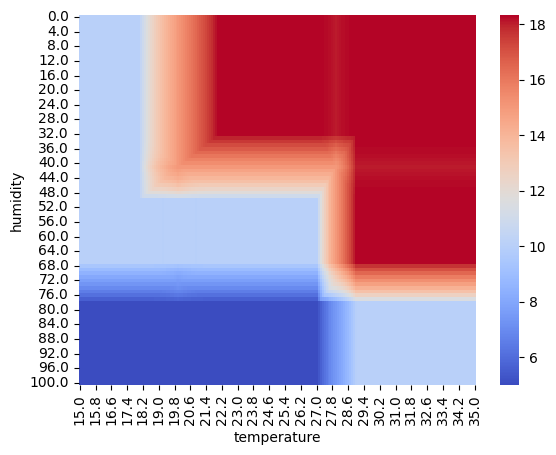

In [5]:
import seaborn as sns
import pandas as pd

# draw pretty watering graph
temperature_grid, humidity_grid = np.meshgrid(np.arange(15, 35.1, 0.1), np.arange(0, 101, 1))
test_points = np.transpose(np.vstack((np.ravel(temperature_grid),np.ravel(humidity_grid))))

model.input['temperature'] = test_points[:,0]
model.input['humidity'] = test_points[:,1]
model.compute()

test_points = np.concatenate((test_points, model.output['water'].reshape(-1,1)), axis=1)

df = pd.DataFrame(test_points, columns=['temperature', 'humidity', 'water'])
df['temperature'] = df['temperature'].round(1)

# Tworzenie heatmapy
sns.heatmap(df.pivot(index='humidity', columns='temperature', values='water'), cmap='coolwarm')

## Zadanie 2

Proszę zaproponować rozmyty system wnioskowania dla dowolnego wybranego (ale różnego od poruszanych dotychczas) problemu. Proszę wziąć pod uwagę co najmniej trzy zmienne wejściowe i każdą zmienną podzielić na co najmniej trzy zbiory rozmyte. Proszę stworzyć co najmniej 5 reguł i skomentować wyniki.

Im rzadziej Państwa pomysły będą się powtarzać, tym lepiej.

In [6]:
# wiper speed control

# define fuzzy variables
rain = ctrl.Antecedent(np.arange(0, 51, 1), 'rain') # mm/h
speed = ctrl.Antecedent(np.arange(0, 121, 1), 'speed') # km/h of the car
light_intensity = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'light_intensity') # light detected by the sensor

wiper_speed = ctrl.Consequent(np.arange(0, 11, 1), 'wiper_speed') # 0 -> off, 10 -> full speed

# define ranges
rain['low']    = fuzz.trimf(rain.universe, [0, 0, 20])
rain['medium'] = fuzz.trimf(rain.universe, [10, 25, 40])
rain['high']   = fuzz.trimf(rain.universe, [30, 50, 50])

speed['slow']     = fuzz.trimf(speed.universe, [0, 0, 50])
speed['moderate'] = fuzz.trimf(speed.universe, [30, 60, 90])
speed['fast']     = fuzz.trimf(speed.universe, [70, 120, 120])

light_intensity['dark']   = fuzz.trimf(light_intensity.universe, [0, 0, 0.3])
light_intensity['moderate'] = fuzz.trimf(light_intensity.universe, [0.2, 0.4, 0.6])
light_intensity['bright']  = fuzz.trimf(light_intensity.universe, [0.5, 1, 1])

wiper_speed['low']    = fuzz.trimf(wiper_speed.universe, [0, 0, 3])
wiper_speed['medium'] = fuzz.trimf(wiper_speed.universe, [2, 5, 8])
wiper_speed['high']   = fuzz.trimf(wiper_speed.universe, [7, 10, 10])

# rules
rule1 = ctrl.Rule(rain['low'] & speed['slow'] & light_intensity['bright'], wiper_speed['low'])
rule2 = ctrl.Rule(rain['low'] & speed['fast'], wiper_speed['medium'])
rule3 = ctrl.Rule(rain['medium'] & speed['moderate'] & light_intensity['moderate'], wiper_speed['medium'])
rule4 = ctrl.Rule(rain['high'] | light_intensity['dark'], wiper_speed['high'])
rule5 = ctrl.Rule(rain['medium'] & speed['fast'], wiper_speed['high'])

# simulate
wiper_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
wiper_sim = ctrl.ControlSystemSimulation(wiper_ctrl)

In [8]:
wiper_sim.input['rain'] = 35  
wiper_sim.input['speed'] = 80  
wiper_sim.input['light_intensity'] = 0.4  
wiper_sim.compute()

print("Wycieraczki będą pracować z prędkością (0-10):", wiper_sim.output['wiper_speed'])

Wycieraczki będą pracować z prędkością (0-10): 6.01103500761035
